In [128]:
using Plots
include("RBFunctions.jl")
path = "presentation_figures/"
using BenchmarkTools

In [27]:
x = [1,3,5,6,8,9]
y = [1,2,4,6,6,2]
axis_color = :black
Plots.scatter(x,y,color = :black,background_color=:transparent,
legend = false,foreground_color_axis = axis_color,
foreground_color_border = axis_color,markersize = 6,
foreground_color_text = axis_color)
savefig(path*"data_sites_1D.png") 

In [3]:
A = hcat(ones(6),x,x.^2,x.^3,x.^4,x.^5)
display(A')
c = inv(A)*y
polynom(x) = sum(c .* [1,x,x^2,x^3,x^4,x^5])
polynom(1.2)
xx = LinRange(0,9,100)
Plots.plot!(xx,polynom.(xx),linewidth = 3)
savefig(path*"polynom_interpolated.png") 

6×6 adjoint(::Matrix{Float64}) with eltype Float64:
 1.0    1.0     1.0     1.0      1.0      1.0
 1.0    3.0     5.0     6.0      8.0      9.0
 1.0    9.0    25.0    36.0     64.0     81.0
 1.0   27.0   125.0   216.0    512.0    729.0
 1.0   81.0   625.0  1296.0   4096.0   6561.0
 1.0  243.0  3125.0  7776.0  32768.0  59049.0

In [4]:
xxx = LinRange(-1,1,100)
Plots.plot(xxx,ones(length(xxx)),background_color=:transparent,
legend = false,foreground_color_axis = axis_color,
foreground_color_border = axis_color,linewidth = 3,
foreground_color_text = axis_color)
for i in 1:5
    Plots.plot!(xxx,xxx.^i,linewidth = 3)
end
savefig(path*"basis.png")

In [65]:
points, _= generate_2D_equally_spaced_points(100)
cam = (30,70)
A = pairwise(Euclidean(), points, 0.5*ones((2,1)), dims=2)
B = pairwise(Euclidean(), points, reshape([0.6,0.7],(2,1)), dims=2)
C = pairwise(Euclidean(), points, reshape([0.3,0.7],(2,1)), dims=2)
A = gaussian.(A,15) # apply RBF to a distance matrix
B = gaussian.(B,15)
C = gaussian.(C,15)
Plots.surface(points[1,:],points[2,:],vec(A .+ B .+ C),camera = cam,background_color=:transparent,
                        legend = false,alpha=0.8,color = :heat)
#Plots.surface!(points[1,:],points[2,:],vec(A),camera = cam,background_color=:transparent,
#legend = false,alpha=0.1,color = :heat)
savefig(path*"RBF_basis.png")

In [119]:
cam2 = (90,50)
halt_points = generate_2D_Halton_points(400)
ff = frankes_func.(halt_points[1,:],halt_points[2,:])
Plots.scatter(halt_points[1,:],halt_points[2,:],ff,camera  =cam,alpha = 0.5,legend=false,color=:black,background_color=:transparent)
Plots.surface!(points[1,:],points[2,:],frankes_func.(points[1,:],points[2,:]),camera =cam2,alpha = 0.2)
savefig(path*"scaterred_data.png")

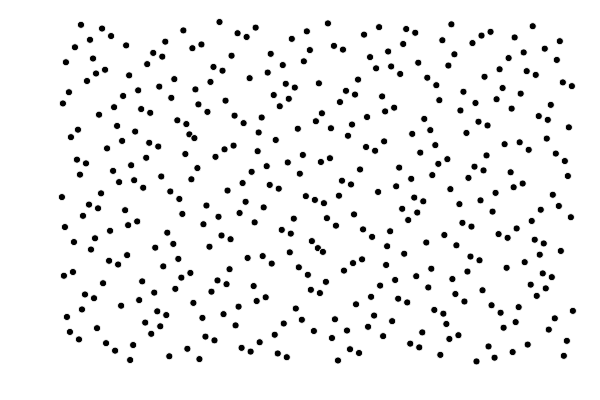

In [123]:
scatter(halt_points[1,:],halt_points[2,:],legend=false,background_color=:transparent,color = :black)

In [147]:
function error(RBF,shape_par,eval_p,coll_p,f_true) # calculate error with given evaluation points and collocation points 
    A = pairwise(Euclidean(), coll_p, coll_p, dims=2)
    A = RBF.(A,shape_par)
    coeff = inv(A) * f_true.(coll_p[1,:],coll_p[2,:]) # find coefficients
    # reconstruct function at evaluation points 
    B = pairwise(Euclidean(), eval_p, coll_p,  dims=2)
    B = RBF.(B,shape_par)
    f_reconstructed = B*coeff
    error_vec = abs.(f_reconstructed-f_true.(eval_p[1,:],eval_p[2,:]))
    error = sqrt(((norm(error_vec))^2)/length(error_vec))
    #error = maximum(error_vec)
    #println(size(f_reconstructed))
    return error
end 

function err_Halton(N,shape_par,RBF,f_true) # error as a function of shape parameter and N 
    N_eval = 200
    coll_points = generate_2D_Halton_points(N)
    eval_points= zeros(Float64,(2,N_eval^2))
    a= LinRange(0.0,1.0,N_eval)
    eval_points[1,:] = vec(ones(N_eval) * a')
    eval_points[2,:] = vec( a* ones(N_eval)')
    return error(RBF,shape_par,eval_points,coll_points,f_true)
end
#@btime err_Halton(60,2,gaussian,frankes_func)
N_range = collect(100:20:1200)
error_list = []
for n in N_range
    append!(error_list,[err_Halton(n,10,gaussian,frankes_func)])
end


In [165]:
plot(N_range[1:50],error_list[1:50],yscale = :log10,color = :black,background_color=:transparent,
legend = false,foreground_color = axis_color,markersize = 6,xlabel="number of scattered points",
ylabel = "log(error)")
savefig(path*"error_tradeoff.png")
#error_list